In [135]:
import pandas as pd
import os

In [154]:
import pandas as pd
import os

column_names = ['Country', 'ZipCode', 'City', 'State', 'StateAbbr', 'County', 'CountyCode', 
                'Empty1', 'Empty2', 'Latitude', 'Longitude', 'Accuracy']

df = pd.read_csv('input_data1/Zip Code to GeoID.txt', sep='\t', header=None, names=column_names)

chicago_df = df[(df['StateAbbr'] == 'IL') & 
                (df['City'].str.contains('Chicago', case=False, na=False))][['ZipCode', 'Longitude', 'Latitude']]

chicago_df.to_csv('clean_data2/chicago_il_zipcodes.csv', index=False)

print(f"Chicago ZIP codes file created: {chicago_df.shape[0]} records")


Chicago ZIP codes file created: 91 records


In [155]:
housing_data = pd.read_csv('input_data1/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

filtered_housing = housing_data[housing_data['City'].isin(['Chicago', 'Chicago Heights', 'Chicago Ridge'])]

date_columns = [col for col in housing_data.columns if col.startswith('20')]

columns_to_keep = ['RegionName', 'SizeRank', 'State'] + date_columns
filtered_housing = filtered_housing[columns_to_keep]

filtered_housing = filtered_housing.rename(columns={'RegionName': 'Zip Code'})

filtered_housing.to_csv('clean_data2/filtered_chicago_housing.csv', index=False)

print(f"Filtered housing data saved: {filtered_housing.shape[0]} records")

Filtered housing data saved: 58 records


In [167]:
# Select only the required columns from the crime dataset
columns_to_keep = ['Date', 'Year', 'Primary Type', 'Location Description', 'Arrest', 'Latitude', 'Longitude']
cleaned_crime_df = crime_df[columns_to_keep]

# Save the cleaned dataset to a CSV file
cleaned_crime_df.to_csv('clean_data2/filtered_chicago_crimes.csv', index=False)

# Print information about the cleaned dataset
print(f"Cleaned crime data saved: {cleaned_crime_df.shape[0]} records")

Cleaned crime data saved: 8304227 records


In [214]:
file_path = 'input_data1/Chicago_Public_SchoolsSY2223.csv'
schools_df = pd.read_csv(file_path)

columns_to_keep = [
    'Long_Name', 'Primary_Category', 'Zip', 'Student_Count_Total', 
    'Student_Count_Low_Income', 'Student_Count_Special_Ed', 'Student_Count_English_Learners', 
    'Student_Count_Black', 'Student_Count_Hispanic', 'Student_Count_White', 
    'Student_Count_Asian', 'Student_Count_Native_American', 'Student_Count_Other_Ethnicity', 
    'Student_Count_Asian_Pacific_Islander', 'Student_Count_Multi', 
    'Student_Count_Hawaiian_Pacific_Islander', 'Student_Count_Ethnicity_Not_Available', 
    'Overall_Rating', 'Rating_Status', 'School_Latitude', 'School_Longitude', 'Location'
]

cleaned_schools_df = schools_df[columns_to_keep]

cleaned_schools_df.loc[:, 'Year'] = 2023

cleaned_schools_df.to_csv('clean_data2/cleaned_chicago_schools.csv', index=False)

/var/folders/h6/655zg1890sg4l1s1rk51_cz00000gn/T/ipykernel_14740/3797911711.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_schools_df.loc[:, 'Year'] = 2023


In [245]:
# Load all datasets
zip_code_df = pd.read_csv('clean_data2/chicago_il_zipcodes.csv')
housing_df = pd.read_csv('clean_data2/filtered_chicago_housing.csv')
crime_df = pd.read_csv('clean_data2/filtered_chicago_crimes.csv')
schools_df = pd.read_csv('clean_data2/cleaned_chicago_schools.csv')

# Print unique counts to understand the data
print(f"ZIP codes unique count: {zip_code_df['ZipCode'].nunique()}")
print(f"Housing ZIP codes unique count: {housing_df['Zip Code'].nunique()}")
print(f"Schools ZIP codes unique count: {schools_df['Zip'].nunique()}")

# Check for common values in the joining columns
print(f"Common ZIP codes between zip_code_df and housing_df: {len(set(zip_code_df['ZipCode'].astype(str)) & set(housing_df['Zip Code'].astype(str)))}")

# Look at data types to ensure they match
print(f"ZIP code types - zip_code_df: {zip_code_df['ZipCode'].dtype}, housing_df: {housing_df['Zip Code'].dtype}, schools_df: {schools_df['Zip'].dtype}")

# Convert ZIP codes to strings for consistent matching
zip_code_df['ZipCode'] = zip_code_df['ZipCode'].astype(str)
housing_df['Zip Code'] = housing_df['Zip Code'].astype(str)
schools_df['Zip'] = schools_df['Zip'].astype(str)

# First merge: ZIP codes with housing data
merged_df = pd.merge(
    zip_code_df,
    housing_df,
    left_on='ZipCode',
    right_on='Zip Code',
    how='inner'
)
print(f"After first merge: {len(merged_df)} rows")

# For crime data, check if exact coordinates match exists
# If not, consider using approximate matching
# First, create a copy of the filtered data to avoid the SettingWithCopyWarning
crime_df_2023 = crime_df[crime_df['Year'] == 2023].copy()

# Round coordinates for approximate matching
merged_df['Latitude_rounded'] = merged_df['Latitude'].round(4)
merged_df['Longitude_rounded'] = merged_df['Longitude'].round(4)
crime_df_2023.loc[:, 'Latitude_rounded'] = crime_df_2023['Latitude'].round(4)
crime_df_2023.loc[:, 'Longitude_rounded'] = crime_df_2023['Longitude'].round(4)

# Group crime data by rounded coordinates and count incidents
crime_summary = crime_df_2023.groupby(['Latitude_rounded', 'Longitude_rounded']).size().reset_index(name='crime_count')

# Second merge: Add crime summary data using rounded coordinates
merged_df = pd.merge(
    merged_df,
    crime_summary,
    on=['Latitude_rounded', 'Longitude_rounded'],
    how='left'
)
print(f"After second merge: {len(merged_df)} rows")

# Fill NaN values in crime_count
merged_df['crime_count'] = merged_df['crime_count'].fillna(0)

# Third merge: Add schools data
merged_df = pd.merge(
    merged_df,
    schools_df,
    left_on='ZipCode',
    right_on='Zip',
    how='left'
)
print(f"After third merge: {len(merged_df)} rows")

# Create output directory if it doesn't exist
output_dir = 'merged_output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the final merged dataset
merged_df.to_csv(os.path.join(output_dir, 'final_merged_dataset.csv'), index=False)
print(f"Merged dataset saved with {len(merged_df)} rows and {len(merged_df.columns)} columns")

ZIP codes unique count: 91
Housing ZIP codes unique count: 58
Schools ZIP codes unique count: 51
Common ZIP codes between zip_code_df and housing_df: 58
ZIP code types - zip_code_df: int64, housing_df: int64, schools_df: int64
After first merge: 58 rows
After second merge: 58 rows
After third merge: 657 rows
Merged dataset saved with 657 rows and 335 columns


/var/folders/h6/655zg1890sg4l1s1rk51_cz00000gn/T/ipykernel_14740/3920652259.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_avg = df_melted.groupby(pd.Grouper(key='date', freq='Y'))['price'].mean().reset_index()


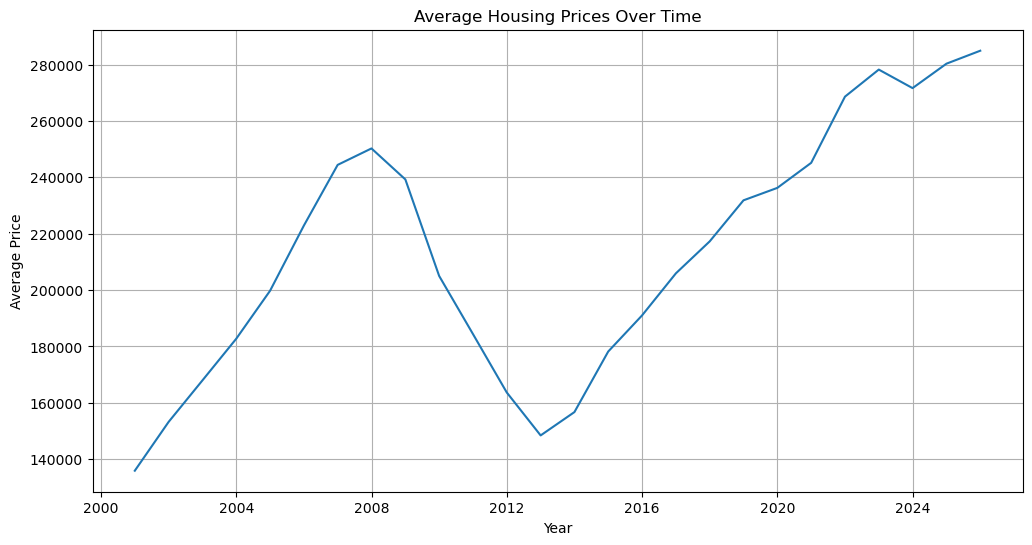

In [257]:
# Step 1: Identify all date columns
date_columns = [col for col in df.columns if col.count('-') == 2 and len(col) == 10]

# Step 2: Melt the dataframe to convert from wide to long format
df_melted = pd.melt(
    df, 
    id_vars=['ZipCode', 'Latitude', 'Longitude'],  # Keep these as identifiers
    value_vars=date_columns,  # Use all date columns
    var_name='date',  # This creates your date column
    value_name='price'  # Assuming these values are housing prices
)

# Step 3: Convert the date column to datetime
df_melted['date'] = pd.to_datetime(df_melted['date'])

# Step 4: Now you can group by date and analyze trends
yearly_avg = df_melted.groupby(pd.Grouper(key='date', freq='Y'))['price'].mean().reset_index()

# Step 5: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg['date'], yearly_avg['price'])
plt.title('Average Housing Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()


/var/folders/h6/655zg1890sg4l1s1rk51_cz00000gn/T/ipykernel_14740/1479793694.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  zip_yearly_avg = df_melted.groupby(['ZipCode', pd.Grouper(key='date', freq='Y')])['price'].mean().reset_index()


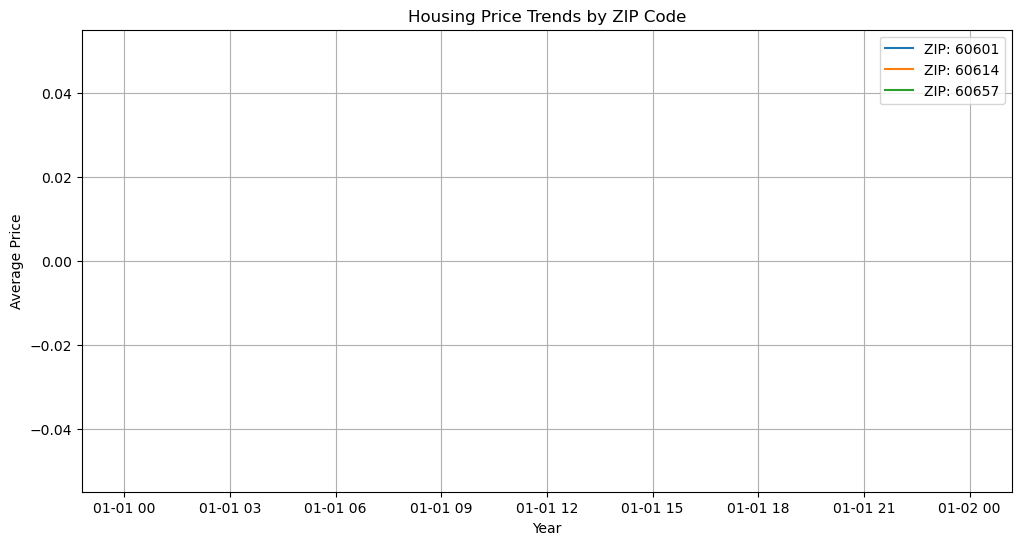

In [259]:
# For ZIP code analysis
zip_yearly_avg = df_melted.groupby(['ZipCode', pd.Grouper(key='date', freq='Y')])['price'].mean().reset_index()

# Then filter for specific ZIP codes to compare them
selected_zips = ['60601', '60614', '60657']  # Example Chicago ZIP codes
zip_comparison = zip_yearly_avg[zip_yearly_avg['ZipCode'].isin(selected_zips)]

# Plot multiple ZIP codes
plt.figure(figsize=(12, 6))
for zip_code in selected_zips:
    data = zip_comparison[zip_comparison['ZipCode'] == zip_code]
    plt.plot(data['date'], data['price'], label=f'ZIP: {zip_code}')
    
plt.title('Housing Price Trends by ZIP Code')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.legend()
plt.grid(True)
plt.show()
